# Fake News Detection Using RNN

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png">

This notebook aims to classify fake news from real news using a recurrent neural network. To simplify the text preprocessing procedure, we will be using the built in functions from tensorflow instead of more established libraries like NLTK.

**Here are the results: **

* Accuracy on testing set: 0.9904231625835189
* Precision on testing set: 0.9879573876794813
* Recall on testing set: 0.9920930232558139

*Free free to provide me with feedbacks.  

**New update: confusion matrix is now expressed in terms of percentage rather than frequency.**


Image Source: https://upload.wikimedia.org/wikipedia/commons/thumb/2/2d/Tensorflow_logo.svg/115px-Tensorflow_logo.svg.png
Code is on my Github: https://github.com/therealcyberlord


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
plt.style.use('ggplot')

from google.colab import drive
import zipfile

In [28]:
import keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Bidirectional, LSTM, Dropout, Embedding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [29]:
from wordcloud import WordCloud

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Read the data

In [31]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/fake news/archive (2).zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Find the CSV files in the zip folder
    fake_path = zip_ref.extract('Fake.csv', '/content/')
    real_path = zip_ref.extract('True.csv', '/content/')

# Read the csv file from the url
fake_df = pd.read_csv(fake_path)
real_df = pd.read_csv(real_path)

# A way to delete rows with empty or null values
fake_df = fake_df[~fake_df.isna().any(axis=1)]
real_df = real_df[~real_df.isna().any(axis=1)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking for null values

In [32]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [33]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Checking for unique values for subject. We want both data frames to have a similar distribution.

In [34]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [35]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Drop the date from the dataset, I don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well.

In [36]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

0 for fake news, and 1 for real news

In [37]:
fake_df['class'] = 0
real_df['class'] = 1

## EDA

Check out the distribution of fake news compare to real news

Text(0, 0.5, 'Proportion of News Articles')

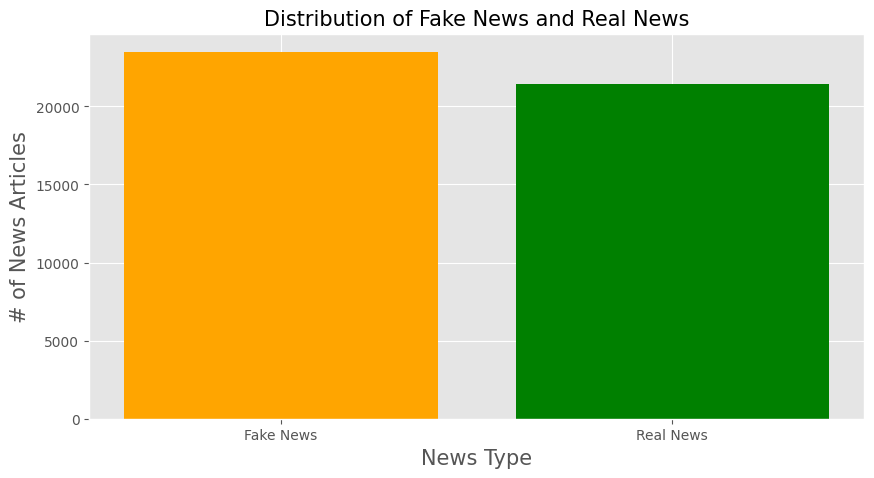

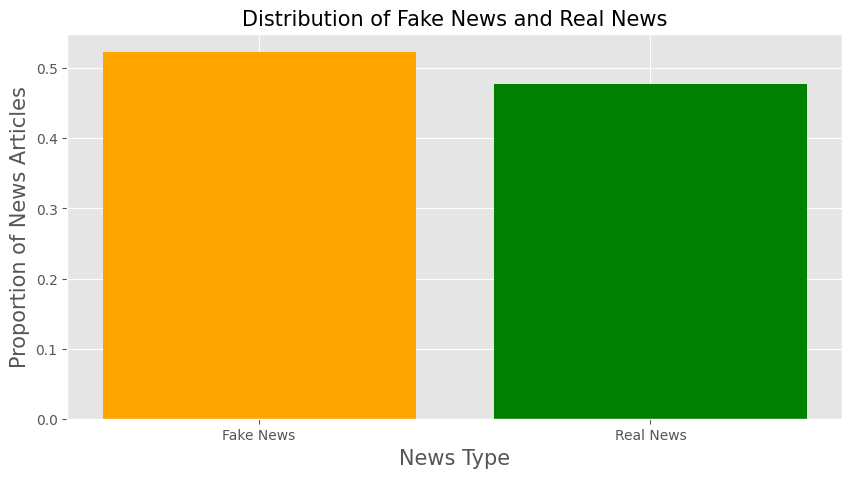

In [38]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [39]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [40]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


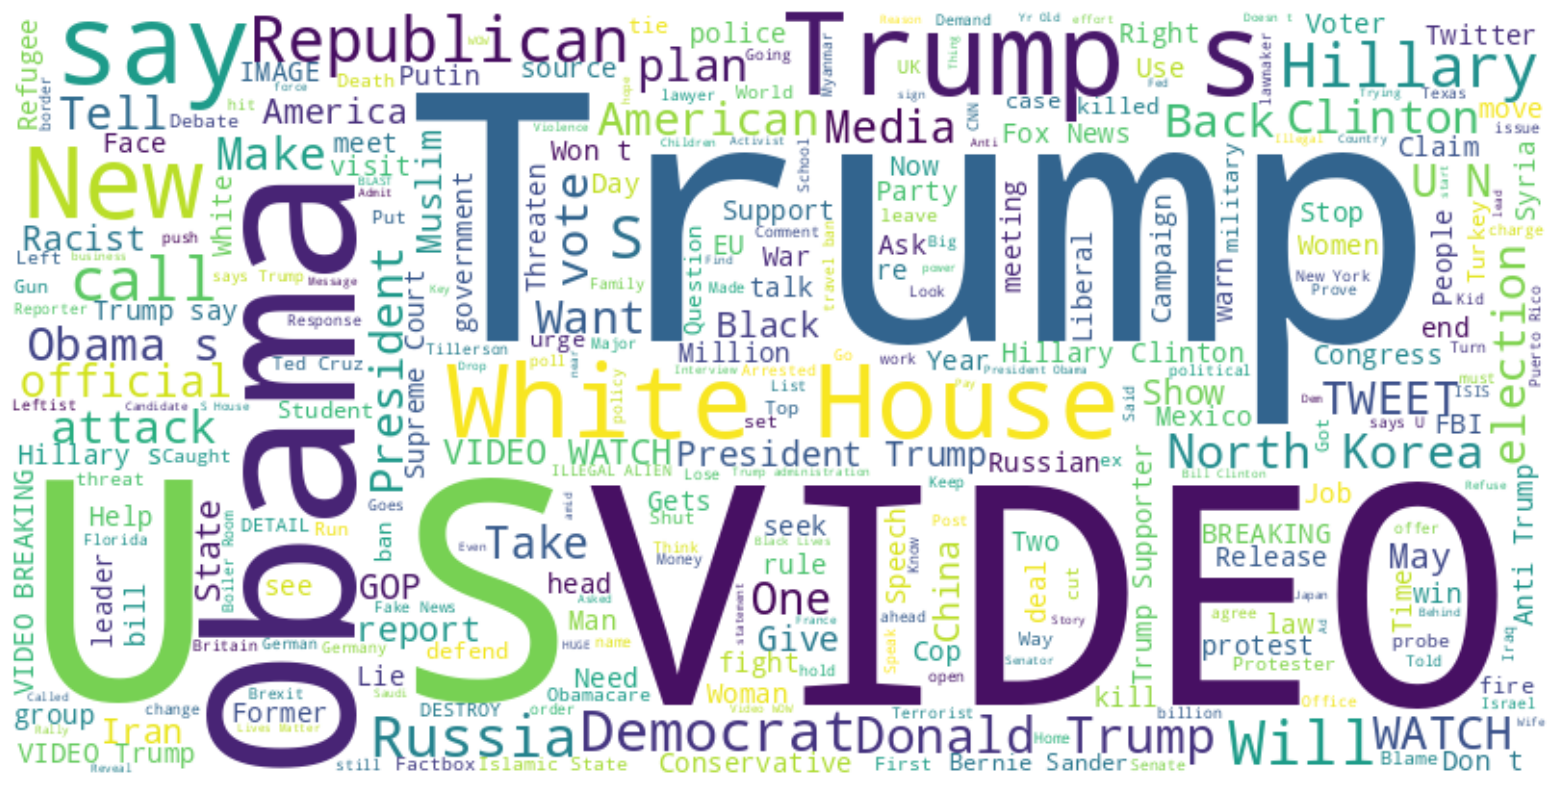

In [48]:
titles = ' '.join(title for title in news_df['title'])
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
news_df['num_words'] = news_df['text'].apply(lambda x: len(x.split()))

In [ ]:
plt.figure(figsize = (20,6))
sns.histplot(news_df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the News Words count')

Combining the title with the text, it is much easier to process this way.

In [ ]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

Split into training and testing

In [ ]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

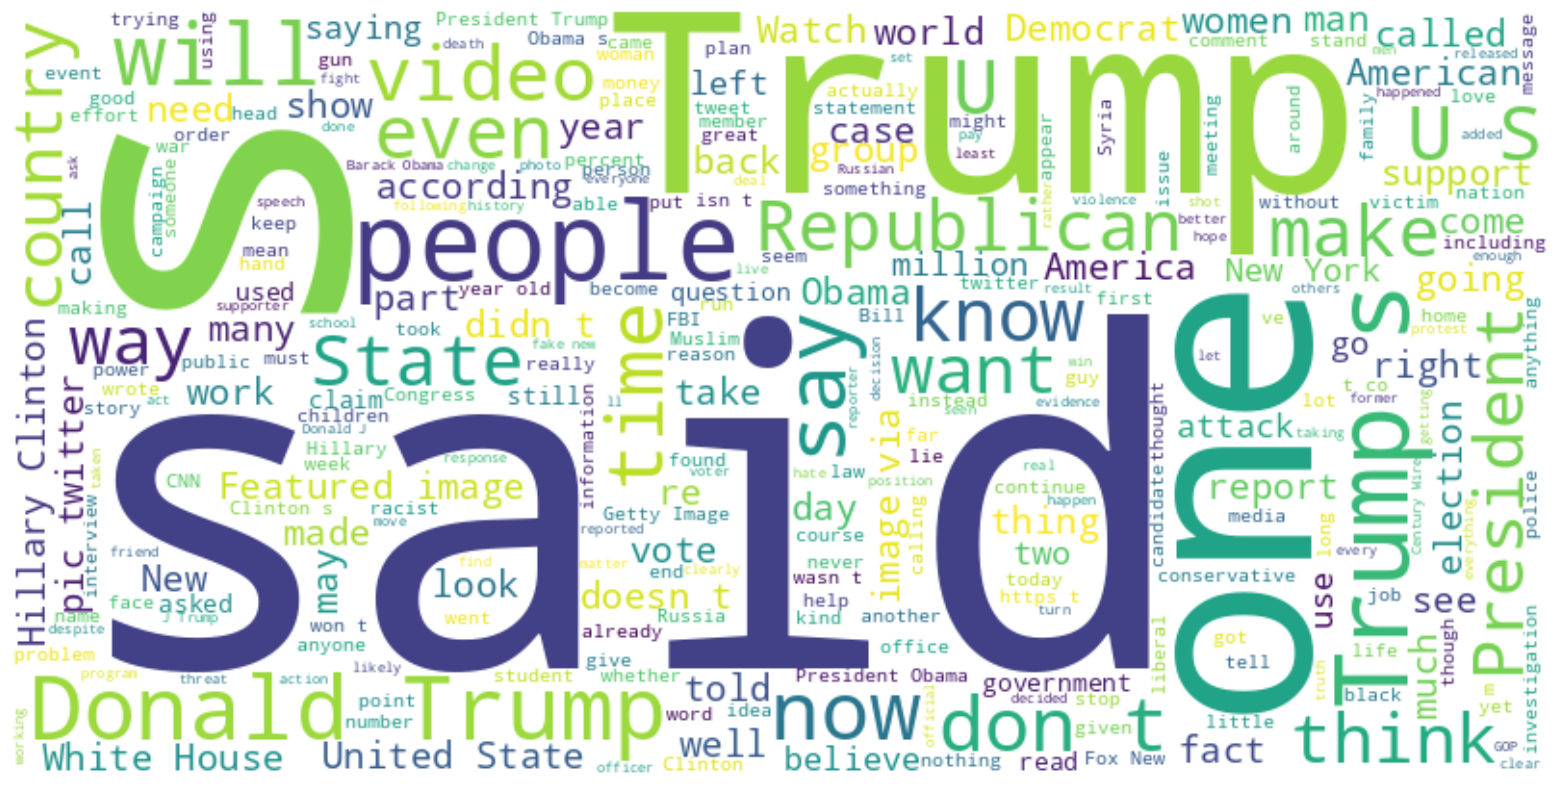

In [49]:
fake_news = X_train[y_train == 0]
real_news = X_train[y_train == 1]
fake_texts = ' '.join(text for text in fake_news)
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(fake_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Machine Learning

### RNN

Normalizing our data: lower case, get rid of extra spaces, and url links.

In [ ]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data.

In [ ]:
# tokenize the text into vectors
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the RNN.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

We are going to use early stop, which stops when the validation loss no longer improve.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Visualize our training over time

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print('F1 score on testing set:', f1_score(binary_predictions, y_test))

Confusion matrix

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

### LSTM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify = targets, random_state = 10)

In [ ]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

In [ ]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)

In [ ]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
model.summary()

In [ ]:
#plot the model architecture
tf.keras.utils.plot_model(model)

In [ ]:
history = model.fit(X_train_seq, y_train, epochs=10,
                    validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

In [ ]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

In [ ]:
#plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## Logistic Regression

In [51]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

In [52]:
LR = LogisticRegression()
LR.fit(xv_train,y_train)

LogisticRegression()

In [53]:
pred_lr=LR.predict(xv_test)

In [54]:
LR.score(xv_test, y_test)

0.9879732739420936

In [55]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5871
           1       0.98      0.99      0.99      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



## Random Forest Classifier

In [56]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)

RandomForestClassifier(random_state=0)

In [57]:
RFC.score(xv_test, y_test)

0.9915367483296214

In [58]:
pred_rfc = RFC.predict(xv_test)

In [60]:
pred_rfc = RFC.predict(xv_test)
RFC.score(xv_test, y_test)

0.9915367483296214

In [61]:
RFC.score(xv_test, y_test)

0.9915367483296214

In [62]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5871
           1       0.99      0.99      0.99      5354

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

